# SWAN procedural example

In this notebook we will use the SWAN Components and data objects to define a SWAN workspace

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from cartopy import crs as ccrs

## Workspace basepath

In [2]:
workdir = Path("example_procedural")
workdir.mkdir(exist_ok=True)

## Model Grid

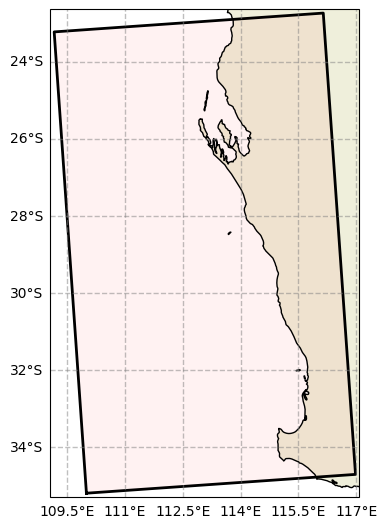

In [3]:
from rompy.swan.grid import SwanGrid

grid = SwanGrid(
    x0=110.0,
    y0=-35.2,
    rot=4.0,
    dx=0.5,
    dy=0.5,
    nx=15,
    ny=25,
)
fig, ax = grid.plot()

## Work with existing data

We will work with subsets of global bathymetry from Gebco and winds from ERA5 available in Rompy. This exercise assumes any processing to the raw forcing data is done with tools outside rompy to handle interpolation or any other required data manipulation.

In [4]:
from rompy.core.types import DatasetCoords
from rompy.core.data import SourceDataset
from rompy.swan.data import SwanDataGrid

In [5]:
DATADIR = Path("../../tests/data")
list(DATADIR.glob("*"))

[PosixPath('../../tests/data/catalog.yaml'),
 PosixPath('../../tests/data/aus-20230101.nc'),
 PosixPath('../../tests/data/gebco-1deg.nc'),
 PosixPath('../../tests/data/era5-20230101.nc')]

In [6]:
def my_fancy_interpolation(dset: xr.Dataset, grid: SwanGrid, coords: DatasetCoords) -> xr.Dataset:
    x0, y0, x1, y1 = grid.bbox()
    xarr = np.arange(x0, x1+grid.dx, grid.dx)
    yarr = np.arange(y0, y1+grid.dy, grid.dy)
    return dset.interp(**{coords.x: xarr, coords.y: yarr})

### Bathy

In [7]:
# Open the global dataset

gebco = xr.open_dataset(DATADIR / "gebco-1deg.nc")
gebco

<xarray.Dataset>
Dimensions:    (lat: 181, lon: 360)
Coordinates:
  * lon        (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * lat        (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 84 85 86 87 88 89 90
Data variables:
    elevation  (lat, lon) float64 ...
Attributes:
    title:    Subset of the GEBCO 2020 grid for testing purposes

In [8]:
# Process it into the model bathy

dset = my_fancy_interpolation(gebco, grid, DatasetCoords(x="lon", y="lat"))
dset

<xarray.Dataset>
Dimensions:    (lat: 26, lon: 17)
Coordinates:
  * lon        (lon) float64 109.2 109.7 110.2 110.7 ... 115.7 116.2 116.7 117.2
  * lat        (lat) float64 -35.2 -34.7 -34.2 -33.7 ... -24.2 -23.7 -23.2 -22.7
Data variables:
    elevation  (lat, lon) float64 -5.397e+03 -5.055e+03 ... 343.3 422.0
Attributes:
    title:    Subset of the GEBCO 2020 grid for testing purposes

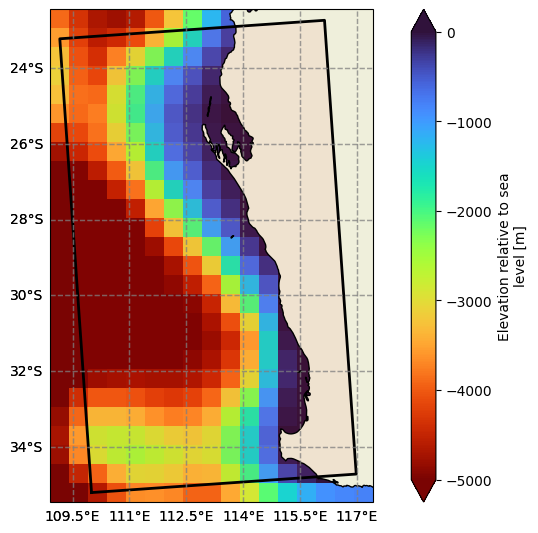

In [9]:
# Create and plot the data instance

bottom = SwanDataGrid(
    var="bottom",
    source=SourceDataset(obj=dset),
    z1="elevation",
    fac=-1,
    coords={"x": "lon", "y": "lat"},
    crop_grid=False, # So data isn't cropped to model grid inside SwanConfig
)

fig, ax = bottom.plot(param="elevation", vmin=-5000, vmax=0, cmap="turbo_r")
fig, ax = grid.plot(ax=ax)

### Winds

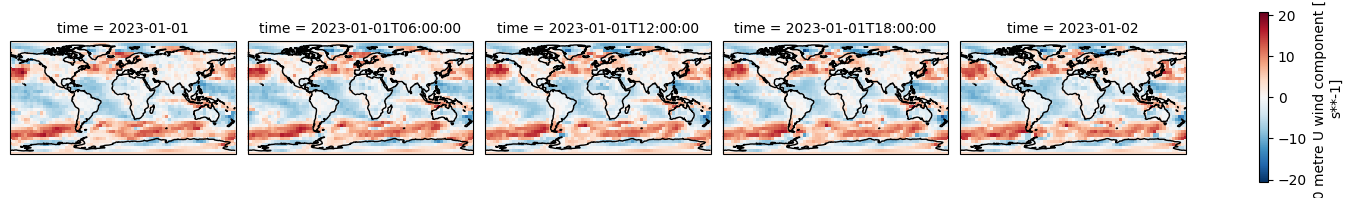

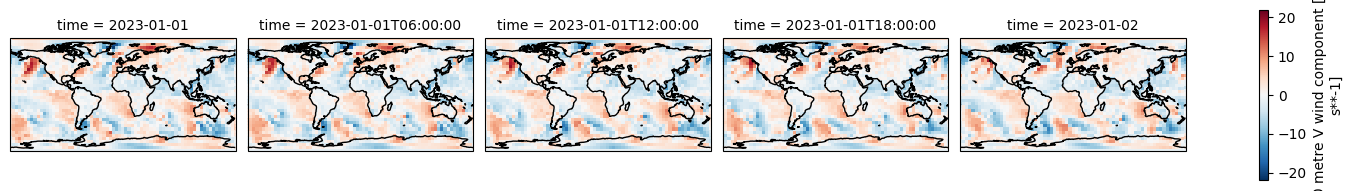

In [10]:
# Open the global dataset

projection = ccrs.PlateCarree()

era5 = xr.open_dataset(DATADIR / "era5-20230101.nc")
fu = era5.u10.plot(col="time", figsize=(15, 2), subplot_kws={"projection": projection})
fv = era5.v10.plot(col="time", figsize=(15, 2), subplot_kws={"projection": projection})
for f in [fu, fv]:
    f.map(lambda: plt.gca().coastlines())

In [11]:
# Process it into the model forcing

dset = my_fancy_interpolation(era5, grid, DatasetCoords(x="longitude", y="latitude"))
dset

<xarray.Dataset>
Dimensions:    (time: 5, latitude: 26, longitude: 17)
Coordinates:
  * time       (time) datetime64[ns] 2023-01-01 ... 2023-01-02
  * longitude  (longitude) float64 109.2 109.7 110.2 110.7 ... 116.2 116.7 117.2
  * latitude   (latitude) float64 -35.2 -34.7 -34.2 -33.7 ... -23.7 -23.2 -22.7
Data variables:
    u10        (time, latitude, longitude) float64 1.002 1.002 ... 2.092 1.241
    v10        (time, latitude, longitude) float64 5.547 5.683 ... 3.777 3.127
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-10 00:03:38 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

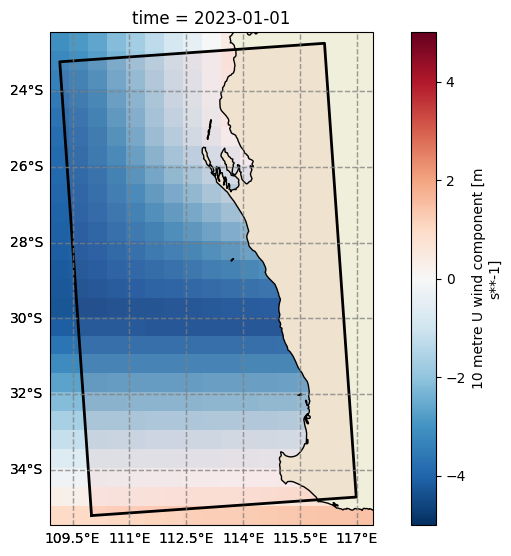

In [12]:
# Create the data instance

wind = SwanDataGrid(
    var="wind",
    source=SourceDataset(obj=dset),
    z1="u10",
    z2="v10",
    coords={"x": "longitude", "y": "latitude"},
    crop_grid=False, # So data isn't cropped to model grid inside SwanConfig
)

fig, ax = wind.plot(param="u10", isel={"time": 0}, vmin=-5, vmax=5, cmap="RdBu_r")
fig, ax = grid.plot(ax=ax)

## SWAN components

SWAN commands can be fully prescribed using what we define as "Components". Components are pydantic
objects that model the different sets of command instruction in SWAN with fields that match the
options for each command and a `render()` method that returns the string to render in the INPUT
command file.

The `SwanConfigComponents` config class takes the components as fields organised as a "group"
components, a collection of individual components that are defined together and validated for
consistency. These groups are structured similarly to the main groups of SWAN commands as
defined by the different subsections in
[Chapter 4](https://swanmodel.sourceforge.io/online_doc/swanuse/node20.html) of the user manual. 

In [13]:
from rompy.swan.config import SwanConfigComponents

SwanConfigComponents?

Init signature:
SwanConfigComponents(
    *,
    model_type: Literal['swanconfig', 'SWANCONFIG'] = 'swanconfig',
    template: str = '/source/csiro/rompy/rompy/templates/swancomp',
    checkout: Optional[str] = 'main',
    cgrid: Union[rompy.swan.components.cgrid.REGULAR, rompy.swan.components.cgrid.CURVILINEAR, rompy.swan.components.cgrid.UNSTRUCTURED],
    startup: Optional[Annotated[rompy.swan.components.group.STARTUP, FieldInfo(annotation=NoneType, required=True, description='Startup components')]] = None,
    inpgrid: Optional[Annotated[Union[rompy.swan.components.group.INPGRIDS, rompy.swan.interface.DataInterface], FieldInfo(annotation=NoneType, required=True, description='Input grid components', discriminator='model_type')]] = None,
    boundary: Optional[Annotated[Union[rompy.swan.components.boundary.BOUNDSPEC, rompy.swan.components.boundary.BOUNDNEST1, rompy.swan.components.boundary.BOUNDNEST2, rompy.swan.components.boundary.BOUNDNEST3, rompy.swan.interface.BoundaryInterface],

### CGRID

In [14]:
from rompy.swan.components.cgrid import REGULAR
from rompy.swan.subcomponents.readgrid import GRIDREGULAR
from rompy.swan.subcomponents.spectrum import SPECTRUM

cgrid = REGULAR(
    grid=GRIDREGULAR(
        xp=grid.x0,
        yp=grid.y0,
        alp=grid.rot,
        xlen=grid.xlen,
        ylen=grid.ylen,
        mx=grid.nx -1,
        my=grid.ny -1,
    ),
    spectrum=SPECTRUM(
        mdc=36,
        flow=0.04,
        fhigh=1.0,
    ),
)

print(cgrid.render())

CGRID REGULAR xpc=110.0 ypc=-35.2 alpc=4.0 xlenc=7.5 ylenc=12.5 mxc=14 myc=24 CIRCLE mdc=36 flow=0.04 fhigh=1.0


### Startup

In [15]:
from rompy.swan.components.group import STARTUP
from rompy.swan.components.startup import PROJECT, SET, MODE, COORDINATES
from rompy.swan.subcomponents.startup import SPHERICAL

project = PROJECT(
    name="Test procedural",
    nr="run1",
    title1="Procedural definition of a Swan config with rompy",
)

set = SET(level=0.0, depmin=0.05, direction_convention="nautical")

mode = MODE(kind="nonstationary", dim="twodimensional")

coordinates = COORDINATES(kind=SPHERICAL())

startup = STARTUP(
    project=project,
    set=set,
    mode=mode,
    coordinates=coordinates,
)

print(startup.render())

PROJECT name='Test procedural' nr='run1' title1='Procedural definition of a Swan config with rompy'

SET level=0.0 depmin=0.05 NAUTICAL

MODE NONSTATIONARY TWODIMENSIONAL

COORDINATES SPHERICAL CCM


### Input grids

The input grids are defined from the SwanDataGrid objects defined in the previous
using the DataInterface object. This object will be interfaced in `SwanConfigComponents`
which will call its `get` method to convert the inputs into SWAN ASCII objects to run
the model.

In [16]:
from rompy.swan.interface import DataInterface

inpgrid = DataInterface(
    bottom=bottom,
    input=[wind],
)

inpgrid

DataInterface(model_type='data_interface', bottom=SwanDataGrid(model_type='data_grid', id='data', source=SourceDataset(model_type='dataset', obj=<xarray.Dataset>
Dimensions:    (lat: 26, lon: 17)
Coordinates:
  * lon        (lon) float64 109.2 109.7 110.2 110.7 ... 115.7 116.2 116.7 117.2
  * lat        (lat) float64 -35.2 -34.7 -34.2 -33.7 ... -24.2 -23.7 -23.2 -22.7
Data variables:
    elevation  (lat, lon) float64 -5.397e+03 -5.055e+03 ... 343.3 422.0
Attributes:
    title:    Subset of the GEBCO 2020 grid for testing purposes), filter=Filter(sort={}, subset={}, crop={}, timenorm={}, rename={}, derived={}), variables=['elevation'], coords=DatasetCoords(t='time', x='lon', y='lat', z='depth'), crop_data=True, buffer=0.0, z1='elevation', z2=None, var=<GridOptions.BOTTOM: 'bottom'>, fac=-1.0), input=[SwanDataGrid(model_type='data_grid', id='data', source=SourceDataset(model_type='dataset', obj=<xarray.Dataset>
Dimensions:    (time: 5, latitude: 26, longitude: 17)
Coordinates:
  * time  

### Boundary

Boundary can be defined either from the BoundaryInterface class or using one of the
existing boundary components.

In [17]:
from rompy.swan.components.boundary import  BOUNDSPEC
from rompy.swan.subcomponents.boundary import SIDE, CONSTANTPAR
from rompy.swan.subcomponents.spectrum import SHAPESPEC, JONSWAP

shape = JONSWAP(gamma=3.3)

shapespec = SHAPESPEC(shape=shape, per_type="peak", dspr_type="degrees")

location = SIDE(side="west", direction="ccw")

data = CONSTANTPAR(hs=2.0, per=12.0, dir=255.0, dd=25.0)

boundary = BOUNDSPEC(shapespec=shapespec, location=location, data=data)

print(boundary.render())

BOUND SHAPESPEC JONSWAP gamma=3.3 PEAK DSPR DEGREES
BOUNDSPEC SIDE WEST CCW CONSTANT PAR hs=2.0 per=12.0 dir=255.0 dd=25.0


### Initial conditions

In [18]:
from rompy.swan.components.boundary import INITIAL
from rompy.swan.subcomponents.boundary import DEFAULT

initial = INITIAL(kind=DEFAULT())

print(initial.render())

INITIAL DEFAULT


### Physics

The Components support every SWAN physics command option. They are prescribed in the 
`SwanConfigComponents` using the PHYSICS group component.

In [19]:
from rompy.swan.components.group import PHYSICS
from rompy.swan.components.physics import GEN3, BREAKING_CONSTANT, FRICTION_RIPPLES, QUADRUPL, TRIAD_DCTA
from rompy.swan.subcomponents.physics import WESTHUYSEN, ELDEBERKY

gen = GEN3(source_terms=WESTHUYSEN(wind_drag="wu", cds2=5.0e-5, br=1.75e-3))

breaking = BREAKING_CONSTANT(alpha=1.0, gamma=0.73)

friction = FRICTION_RIPPLES(s=2.65, d=0.0001)

triad = TRIAD_DCTA(trfac=4.4, p=1.333, biphase=ELDEBERKY(urcrit=0.63))

quad = QUADRUPL(iquad=2, lambd=0.25, cn14=3.0e7, csh1=5.5, csh2=0.833, csh3=-1.25)

physics = PHYSICS(
    gen=gen,
    breaking=breaking,
    friction=friction,
    triad=triad,
    quadrupl=quad,
)

print(physics.render())

GEN3 WESTHUYSEN cds2=5e-05 br=0.00175 DRAG WU

QUADRUPL iquad=2 lambda=0.25 Cn14=30000000.0 Csh1=5.5 Csh2=0.833 Csh3=-1.25

BREAKING CONSTANT alpha=1.0 gamma=0.73

FRICTION RIPPLES S=2.65 D=0.0001

TRIAD DCTA trfac=4.4 p=1.333 COLL BIPHASE ELDEBERKY urcrit=0.63


### Propagation scheme

In [20]:
from rompy.swan.components.numerics import PROP
from rompy.swan.subcomponents.numerics import BSBT

prop = PROP(scheme=BSBT())

print(prop.render())

PROP BSBT


### Numerics

In [21]:
from rompy.swan.components.numerics import NUMERIC
from rompy.swan.subcomponents.numerics import STAT, STOPC, DIRIMPL

stopc = STOPC(dabs=0.005, drel=0.01, curvat=0.005, npnts=99.5, mode=STAT(mxitst=50))

dirimpl = DIRIMPL(cdd=0.5)

numeric = NUMERIC(stopc=stopc, dirimpl=dirimpl)

print(numeric.render())

NUMERIC STOPC dabs=0.005 drel=0.01 curvat=0.005 npnts=99.5 STATIONARY mxitst=50 DIRIMPL cdd=0.5


### Output

Output commands are defined in `SwanConfigComponents` with the `OUTPUT` group component.
Many validations are defined to ensure location and write components are correctly defined.

The output write components (and the lockup ones) need times to be prescribed, however
we skip defining times here as `SwanConfigComponents` will ensure consistent times are
defined for every time-dependant component.  

In [22]:
from rompy.swan.components.group import OUTPUT
from rompy.swan.components.output import POINTS, QUANTITY, QUANTITIES, BLOCK, TABLE
from rompy.swan.subcomponents.time import TimeRangeOpen

points = POINTS(
    sname="pts",
    xp=[114.0, 112.5, 115.0],
    yp=[-34.0, -26.0, -30.0],
)

q1 = QUANTITY(output=["hsign"], hexp=50.0)
q2 = QUANTITY(output=["hsign", "tps"], fmin=0.04, fmax=0.3)
q3 = QUANTITY(output=["hswell"], fswell=0.125)
quantity = QUANTITIES(quantities=[q1, q2, q3])

block = BLOCK(
    sname="COMPGRID",
    fname=str(workdir / "outgrid.nc"),
    output=["hsign", "hswell", "dir", "tps", "depth"],
    times=TimeRangeOpen(tfmt=1, dfmt="min"), # Use the default time values for now, they will be overridden
    idla=3,
)

table = TABLE(
    sname="pts",
    fname=str(workdir / "outpts.nc"),
    output=["hsign", "dir", "tps", "tm01", "qp"],
    times=TimeRangeOpen(tfmt=1, dfmt="min"),
)

output = OUTPUT(points=points, quantity=quantity, block=block, table=table)

print(output.render())

POINTS sname='pts' &
    xp=114.0 yp=-34.0 &
    xp=112.5 yp=-26.0 &
    xp=115.0 yp=-30.0

QUANTITY HSIGN hexp=50.0

QUANTITY HSIGN TPS fmin=0.04 fmax=0.3

QUANTITY HSWELL fswell=0.125

BLOCK sname='COMPGRID' fname='example_procedural/outgrid.nc' LAYOUT idla=3 &
    HSIGN &
    HSWELL &
    DIR &
    TPS &
    DEPTH &
    OUTPUT tbegblk=19700101.000000 deltblk=60.0 MIN

TABLE sname='pts' fname='example_procedural/outpts.nc' &
    HSIGN &
    DIR &
    TPS &
    TM01 &
    QP &
    OUTPUT tbegtbl=19700101.000000 delttbl=60.0 MIN


### Lockup

The lockup components are prescribed to the `SwanConfigComponents` class from the `LOCKUP`
group component. similar to the output components, time-based fields do not need to be
prescribed as they will be reset in the config class, however some time parameters such as
`tfmt` and `dfmt` are maintained if defined so they could be defined here.

In [23]:
from rompy.swan.components.group import LOCKUP
from rompy.swan.components.lockup import COMPUTE_STAT, HOTFILE
from rompy.swan.subcomponents.time import NONSTATIONARY

hotfile = HOTFILE(fname=str(workdir / "hotfile.swn"), format="free")

compute = COMPUTE_STAT(
    times=NONSTATIONARY(tfmt=1, dfmt="hr"), # We use nonstationary times here to prescribe multiple STAT commands
    hotfile=hotfile,
    hottimes=[1, -1], # Output hotfile after the 2nd and last time steps
)

lockup = LOCKUP(compute=compute)

print(lockup.render())

COMPUTE STATIONARY time=19700101.000000
COMPUTE STATIONARY time=19700101.010000
HOTFILE fname='example_procedural/hotfile_19700101T010000.swn' FREE
COMPUTE STATIONARY time=19700101.020000
COMPUTE STATIONARY time=19700101.030000
COMPUTE STATIONARY time=19700101.040000
COMPUTE STATIONARY time=19700101.050000
COMPUTE STATIONARY time=19700101.060000
COMPUTE STATIONARY time=19700101.070000
COMPUTE STATIONARY time=19700101.080000
COMPUTE STATIONARY time=19700101.090000
COMPUTE STATIONARY time=19700101.100000
COMPUTE STATIONARY time=19700101.110000
COMPUTE STATIONARY time=19700101.120000
COMPUTE STATIONARY time=19700101.130000
COMPUTE STATIONARY time=19700101.140000
COMPUTE STATIONARY time=19700101.150000
COMPUTE STATIONARY time=19700101.160000
COMPUTE STATIONARY time=19700101.170000
COMPUTE STATIONARY time=19700101.180000
COMPUTE STATIONARY time=19700101.190000
COMPUTE STATIONARY time=19700101.200000
COMPUTE STATIONARY time=19700101.210000
COMPUTE STATIONARY time=19700101.220000
COMPUTE STAT

### Instantiate config

Note each field is optional so it is possible to skip defining a certain group component
such as `prop` to allow using default options in SWAN.

In [24]:
config = SwanConfigComponents(
    cgrid=cgrid,
    startup=startup,
    inpgrid=inpgrid,
    initial=initial,
    boundary=boundary,
    physics=physics,
    prop=prop,
    numeric=numeric,
    output=output,
    lockup=lockup,
)

### Generate workspace

The config `SwanConfigComponents` is not one of the declared types in the `config` field
of `ModelRun`. This is okay here since we are passing the config object, but it would
result in an exception if we were trying to instantiate it from a dictionary.

In [25]:
from rompy.model import ModelRun
from rompy.core.time import TimeRange

start, end = era5.time.to_index()[[0, -1]]

run = ModelRun(
    run_id="test_procedural",
    period=TimeRange(start=start, end=end, interval="1h"),
    output_dir=str(workdir),
    config=config,
)

rundir = run.generate()

INFO:rompy.model:
INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Model settings:
INFO:rompy.model:
period: 

	Start: 2023-01-01 00:00:00
	End: 2023-01-02 00:00:00
	Duration: 1 days 00:00:00
	Interval: 1:00:00
	Include End: True


output_dir: 
example_procedural

config: 
model_type='swanconfig' template='/source/csiro/rompy/rompy/templates/swancomp' checkout='main' cgrid=REGULAR(model_type='regular', spectrum=SPECTRUM(model_type='spectrum', mdc=36, flow=0.04, fhigh=1.0, msc=None, dir1=None, dir2=None), grid=GRIDREGULAR(model_type='gridregular', xp=110.0, yp=-35.2, alp=4.0, xlen=7.5, ylen=12.5, mx=14, my=24, suffix='c')) startup=STARTUP(model_type='startup', project=PROJECT(model_type='project', name='Test procedural', nr='run1', title1='Procedural definition of a Swan config with rompy', title2=None, title3=None), set=SET(model_type='set', level=0.0, nor=None, depmin=0.05, maxmes=None, maxerr=None, grav=None, rho=None, cdcap=None, inrhog=None, h

### Check the workspace

In [26]:
list(Path(rundir).glob("*"))

[PosixPath('/source/csiro/rompy/notebooks/swan/example_procedural/test_procedural/bottom.grd'),
 PosixPath('/source/csiro/rompy/notebooks/swan/example_procedural/test_procedural/INPUT'),
 PosixPath('/source/csiro/rompy/notebooks/swan/example_procedural/test_procedural/wind.grd')]

In [27]:
input = Path("/source/csiro/rompy/notebooks/swan/test_procedural/test_procedural/INPUT")
print(input.read_text())

! Rompy SwanConfig
! Template: /source/csiro/rompy/rompy/templates/swancomp
! Generated: 2023-10-15 08:07:44.751336 on rafael-XPS by rguedes


! Startup -------------------------------------------------------------------------------------------------------------------------------------------------------------------------

PROJECT name='Test procedural' nr='run1' title1='Procedural definition of a Swan config with rompy'

SET level=0.0 depmin=0.05 NAUTICAL

MODE NONSTATIONARY TWODIMENSIONAL

COORDINATES SPHERICAL CCM

! Computational Grid --------------------------------------------------------------------------------------------------------------------------------------------------------------


CGRID REGULAR xpc=110.0 ypc=-35.2 alpc=4.0 xlenc=7.5 ylenc=12.5 mxc=14 myc=24 CIRCLE mdc=36 flow=0.04 fhigh=1.0

! Input Grids ---------------------------------------------------------------------------------------------------------------------------------------------------------------------

I

## Run the model

Todo

## Plot outputs

Todo